## Work-in-Progress!
Looking into schedule changes for LAG-BAOMER (ל"ג בעומר) 2018.  
Changes are (supposedly?) attributed to the [הילולת רבי שמעון בר יוחאי](https://he.wikipedia.org/wiki/%D7%94%D7%99%D7%9C%D7%95%D7%9C%D7%AA_%D7%A8%D7%91%D7%99_%D7%A9%D7%9E%D7%A2%D7%95%D7%9F_%D7%91%D7%A8_%D7%99%D7%95%D7%97%D7%90%D7%99) which takes place at Mount Meron.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ftplib import FTP
import datetime
import re
import zipfile
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10) # set default size of plots

sns.set_style("white")
sns.set_context("talk")
sns.set_palette('Set1', 10)

## Get the data
I get all the files from our GTFS repository at הסדנא - it is not still openly accessible, but you can ask me for files or access if you need it.  

## Tidy it up
Using [partridge](https://github.com/remix/partridge/tree/master/partridge) for filtering on dates, and then some tidying up and transformations.

In [2]:
from gtfs_utils import *

TARIFF_FILE_NAME = 'Tariff.zip'
TARIFF_TXT_NAME = 'Tariff.txt'
TARIFF_TO_REFORM_ZONE = 'StationToReformZone.txt'
local_tariff_path = 'data/sample/tariff.zip' 

conn = ftp_connect()
get_ftp_file(conn, file_name = TARIFF_FILE_NAME, local_zip_path = local_tariff_path )

### Tariff stuff for zone names

In [3]:
# not a true csv, so we need to jiggle it a bit
cols = ['ShareCode','ShareCodeDesc','ZoneCodes','Daily','Weekly','Monthly','FromDate','ToDate', 'EXTRA']
reform_cols = ['StationId', 'ReformZoneCode','FromDate','ToDate', 'EXTRA']
with zipfile.ZipFile(local_tariff_path) as zf:
    tariff_df = (pd.read_csv(zf.open(TARIFF_TXT_NAME), header=None, skiprows=[0], names = cols)
                .drop(columns = ['EXTRA']))
    reform_df = (pd.read_csv(zf.open(TARIFF_TO_REFORM_ZONE), header=None, skiprows=[0], names = reform_cols)
                 .drop(columns = ['EXTRA']))

    
# remove ShareCodes which contain multiple zones  e.g. גוש דן מורחב
tariff_df = (tariff_df[~ tariff_df.ZoneCodes.str.contains(';')]
             .rename(columns = {'ShareCodeDesc': 'zone_name',
                               'ZoneCodes': 'zone_id'}))
rs = reform_df[['StationId', 'ReformZoneCode']].drop_duplicates().applymap(str).set_index('StationId').iloc[:,0]

ts = (tariff_df[['zone_id', 'zone_name']].drop_duplicates().set_index('zone_id').iloc[:,0])
zones = rs.map(ts).reset_index().rename(columns={'StationId': 'stop_code', 'ReformZoneCode':'zone_name'})

In [4]:
import partridge as ptg

def get_partridge_feed(zip_path, date):
    service_ids_by_date = ptg.read_service_ids_by_date(zip_path)
    service_ids = service_ids_by_date[date]

    feed = ptg.feed(zip_path, view={
        'trips.txt': {
            'service_id': service_ids,
        },
    })
    return feed
    
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time', 'departure_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df

def get_tidy_feed_df(feed, zones):
    s = feed.stops
    r = feed.routes
    t = (feed.trips
         .assign(route_id=lambda x: pd.Categorical(x['route_id'])))
    f = (feed.stop_times[['trip_id', 'departure_time', 'arrival_time', 'stop_id', 'stop_sequence']]
         .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'stop_code']], on='stop_id')
         # Much faster joins and slices with Categorical dtypes
         .merge(zones, how='left')
         .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
         .merge(t[['trip_id', 'route_id', 'direction_id']], on='trip_id')
         .merge(r[['route_id', 'route_short_name', 'route_long_name']], on='route_id')
         .assign(route_id=lambda x: pd.Categorical(x['route_id']))
         .pipe(to_timedelta)
        )
    return f

In [5]:
LOCAL_ZIP_PATH1 = 'data/gtfs_feeds/2018-05-01.zip' 
LOCAL_ZIP_PATH2 = 'data/gtfs_feeds/2018-05-02.zip' 
LOCAL_ZIP_PATH3 = 'data/gtfs_feeds/2018-04-25.zip' 

### LAG-BAOMER feeds

In [6]:
feed2 = get_partridge_feed(LOCAL_ZIP_PATH2, datetime.date(2018, 5, 2))
feed3 = get_partridge_feed(LOCAL_ZIP_PATH2, datetime.date(2018, 5, 3))

### Last week's feeds

In [15]:
feed25 = get_partridge_feed(LOCAL_ZIP_PATH3, datetime.date(2018, 4, 25))
feed26 = get_partridge_feed(LOCAL_ZIP_PATH3, datetime.date(2018, 4, 26))

In [16]:
print('(Last Wed - This Wed): %.3f' % ((feed25.trips.shape[0] - feed2.trips.shape[0])/feed25.trips.shape[0]))
print('(Last Thu - This Wed): %.3f' % ((feed26.trips.shape[0] - feed3.trips.shape[0])/feed25.trips.shape[0]))

(Last Wed - This Wed): 0.030
(Last Thu - This Wed): 0.074


In [17]:
f25 = get_tidy_feed_df(feed25, zones)
f26 = get_tidy_feed_df(feed26, zones)

In [18]:
f2 = get_tidy_feed_df(feed2, zones)
f3 = get_tidy_feed_df(feed3, zones)

In [19]:
zones.zone_name.value_counts()

גוש דן                       4551
סובב ירושלים                 2800
סובב חיפה                    2416
נתניה                        1610
שרון                         1472
נצרת                         1421
נהריה                        1312
גליל עליון ורמת הגולן        1294
כרמיאל                       1039
חריש ואדי ערה                1003
עכו                           987
אשדוד                         968
רחובות                        927
באר שבע                       842
ראש העין שוהם                 824
אשקלון                        775
סובב כנרת ודרום רמת הגולן     700
עפולה                         678
יוקנעם- טבעון                 670
חבל מודיעין                   668
ערד דימונה                    619
נתיבות שדרות                  561
אזור בית שמש                  525
אזור חדרה                     484
רהט להבים                     460
הרי ירושלים                   432
קריית גת                      343
בית שאן                       326
השומרון                       318
אופקים        

### Zone-specific difference ratio

In [20]:
danwed = f25[f25.zone_name=="גוש דן"].trip_id.nunique() - f2[f2.zone_name=="גוש דן"].trip_id.nunique()
danthu = f26[f26.zone_name=="גוש דן"].trip_id.nunique() - f3[f3.zone_name=="גוש דן"].trip_id.nunique()
haiwed = f25[f25.zone_name=="סובב חיפה"].trip_id.nunique() - f2[f2.zone_name=="סובב חיפה"].trip_id.nunique()
haithu = f26[f26.zone_name=="סובב חיפה"].trip_id.nunique() - f3[f3.zone_name=="סובב חיפה"].trip_id.nunique()
akowed = f25[f25.zone_name=="עכו"].trip_id.nunique() - f2[f2.zone_name=="עכו"].trip_id.nunique()
akothu = f26[f26.zone_name=="עכו"].trip_id.nunique() - f3[f3.zone_name=="עכו"].trip_id.nunique()
nahwed = f25[f25.zone_name=="נהריה"].trip_id.nunique() - f2[f2.zone_name=="נהריה"].trip_id.nunique()
nahthu = f26[f26.zone_name=="נהריה"].trip_id.nunique() - f3[f3.zone_name=="נהריה"].trip_id.nunique()

In [21]:
netwed = f25[f25.zone_name=="נתניה"].trip_id.nunique() - f2[f2.zone_name=="נתניה"].trip_id.nunique()
netthu = f26[f26.zone_name=="נתניה"].trip_id.nunique() - f3[f3.zone_name=="נתניה"].trip_id.nunique()

In [22]:
print('Gush Dan Wed: %.2f' % (danwed / f25[f25.zone_name=="גוש דן"].trip_id.nunique()))
print('Gush Dan Thu: %.2f' % (danthu / f26[f26.zone_name=="גוש דן"].trip_id.nunique()))
print('Haifa Wed: %.2f' % (haiwed / f25[f25.zone_name=="סובב חיפה"].trip_id.nunique()))
print('Haifa Thu: %.2f' % (haithu / f26[f26.zone_name=="סובב חיפה"].trip_id.nunique()))
print('Akko Wed: %.2f' % (akowed / f25[f25.zone_name=="עכו"].trip_id.nunique()))
print('Akko Thu: %.2f' % (akothu / f26[f26.zone_name=="עכו"].trip_id.nunique()))
print('Nahariya Wed: %.2f' % (nahwed / f25[f25.zone_name=="נהריה"].trip_id.nunique()))
print('Nahariya Thu: %.2f' % (nahthu / f26[f26.zone_name=="נהריה"].trip_id.nunique()))
print('Netanya Wed: %.2f' % (netwed / f25[f25.zone_name=="נתניה"].trip_id.nunique()))
print('Netanya Thu: %.2f' % (netthu / f26[f26.zone_name=="נתניה"].trip_id.nunique()))


Gush Dan Wed: 0.03
Gush Dan Thu: 0.06
Haifa Wed: 0.04
Haifa Thu: 0.16
Akko Wed: 0.16
Akko Thu: 0.20
Nahariya Wed: 0.13
Nahariya Thu: 0.16
Netanya Wed: 0.02
Netanya Thu: 0.07


### Per route trip count difference

In [23]:
rcmp = pd.concat([feed26.trips.route_id.value_counts(), feed3.trips.route_id.value_counts()], axis=1, keys=['feed26', 'feed3'])

rcmp['dif'] = rcmp.feed26.subtract(rcmp.feed3)
pd.concat((rcmp, feed26.routes.set_index('route_id')[['route_short_name', 'route_long_name']]), axis=1).sort_values(by='dif', ascending=False).head(20)

,feed26,feed3,dif,route_short_name,route_long_name
15729,117.0,55.0,62.0,2,אבא שאול/איסוף-ביתר עילית<->דרך הרמ''ז/מפעל הש...
15730,116.0,55.0,61.0,2,דרך הרמז/סדיגורא-ביתר עילית<->אבא שאול/הורדה-ב...
10516,116.0,67.0,49.0,5,בית כנסת/הרב שך-ביתר עילית<->בית כנסת/הרב שך-ב...
10811,116.0,69.0,47.0,68,האוניברסיטה העברית הר הצופים-ירושלים<->האונ' ה...
10944,93.0,56.0,37.0,6,קדושת לוי/ברוק-ביתר עילית<->בית כנסת/הרב שך-בי...
10943,92.0,56.0,36.0,6,בית כנסת/הרב שך-ביתר עילית<->קדושת לוי/ברוק-בי...
10252,68.0,33.0,35.0,59,ביטוח לאומי-ירושלים<->וינוגרד/זווין-ירושלים-1#
2117,112.0,77.0,35.0,3,ת. מרכזית נתניה-נתניה<->ת. מרכזית נתניה-נתניה-3#
1130,95.0,61.0,34.0,62,בן ציון גליס/צבי ברגמן-פתח תקווה<->מסוף שניידר...
12406,87.0,54.0,33.0,15,האומן/ברעם-ירושלים<->בנייני האומה-ירושלים-2#


### Per minute departure difference

In [24]:
se = (feed3.stop_times.groupby(['trip_id'])
     .agg({'departure_time': 'min',
          'arrival_time': 'max'})
     .pipe(to_timedelta)
     .sort_values(['arrival_time', 'departure_time']))
se.head()

,departure_time,arrival_time
trip_id,,
31908291_030518,00:00:00,00:11:34
31134617_030518,00:00:00,00:11:54
31973562_030518,00:00:00,00:12:17
15347769_030518,00:05:00,00:12:37
26424664_030518,00:05:00,00:17:00


In [25]:
se2 = (feed26.stop_times.groupby(['trip_id'])
     .agg({'departure_time': 'min',
          'arrival_time': 'max'})
     .pipe(to_timedelta)
     .sort_values(['arrival_time', 'departure_time']))
se2.head()

,departure_time,arrival_time
trip_id,,
31908288_240418,00:00:00,00:11:34
31134614_240418,00:00:00,00:11:54
26125699_240418,00:00:00,00:12:17
13660343_240418,00:05:00,00:12:37
25359099_240418,00:05:00,00:17:00


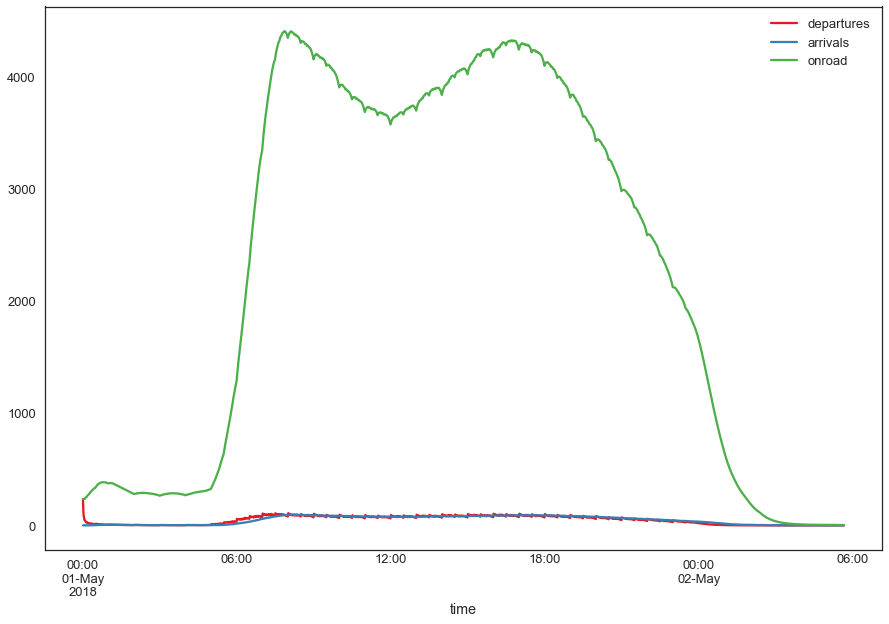

In [77]:
departures = pd.Series(1, se.departure_time).resample('1Min').sum()
arrivals =  pd.Series(1, se.arrival_time).resample('T').sum()
onroad = pd.concat([pd.Series(1, se.departure_time),  # departed add 1
                           pd.Series(-1, se.arrival_time)  # arrived substract 1
                           ]).resample('1Min').sum().cumsum().ffill()
df = (pd.concat([departures, arrivals, onroad], axis=1).reset_index()
        .rename(columns={'index': 'time', 0:'departures', 1:'arrivals', 2:'onroad'}))
idx = pd.DatetimeIndex(df.time+datetime.datetime(2018, 5, 1))

(df.assign(time=idx)
 .set_index('time')
 .resample('1min').sum()
 .ewm(span=60)
 .mean()
 .plot())

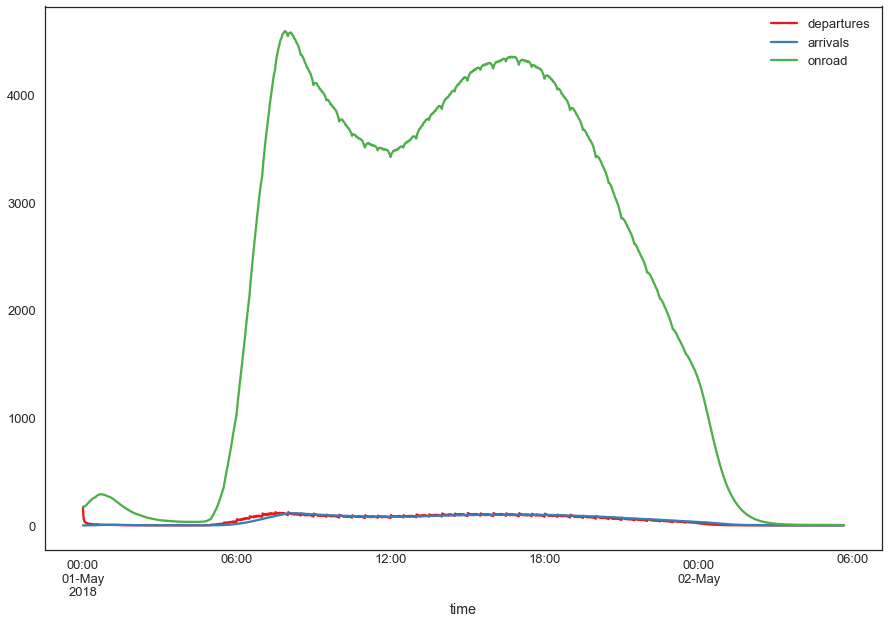

In [78]:
departures2 = pd.Series(1, se2.departure_time).resample('1Min').sum()
arrivals2 =  pd.Series(1, se2.arrival_time).resample('T').sum()
onroad2 = pd.concat([pd.Series(1, se2.departure_time),  # departed add 1
                           pd.Series(-1, se2.arrival_time)  # arrived substract 1
                           ]).resample('1Min').sum().cumsum().ffill()
df2 = (pd.concat([departures2, arrivals2, onroad2], axis=1).reset_index()
        .rename(columns={'index': 'time', 0:'departures', 1:'arrivals', 2:'onroad'}))
#idx = pd.DatetimeIndex(df.time+datetime.datetime(2018, 5, 1))

(df2.assign(time=idx)
 .set_index('time')
 .resample('1min').sum()
 .ewm(span=60)
 .mean()
 .plot())

This looks almost the same, lets line the departures up

Text(0.5,1,'Departures Per Minute (smoothed)')

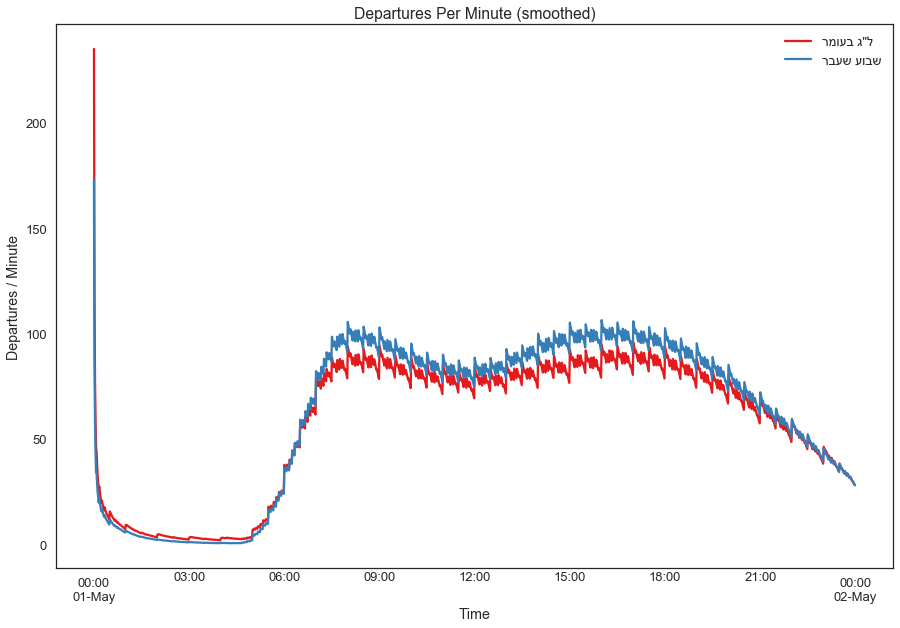

In [79]:
idx = pd.DatetimeIndex(departures.index+datetime.datetime(2018, 5, 1))

df_m = (pd.concat([departures, departures2], axis=1).reset_index()
        .rename(columns={'index': 'time', 1:'רבעש עובש', 0:'רמועב ג"ל'}))
fig, ax = plt.subplots()

(df_m.assign(time=idx)
 .set_index('time')
 .resample('1min').sum()
 .ewm(span=120)
 .mean()
 .plot(ax=ax))

ax.set_xlabel('Time')
ax.set_ylabel('Departures / Minute')
ax.set_title('Departures Per Minute (smoothed)')

## GTFSTK

Now for some statistical heavy-lifting I'll use [GTFSTK](https://github.com/mrcagney/gtfstk).

In [35]:
import gtfstk as gt
import shapely.geometry as sg

In [36]:
# List feed

gt.list_gtfs(LOCAL_ZIP_PATH2)

,file_name,file_size
0,agency.txt,2027
1,calendar.txt,1670513
2,fare_attributes.txt,8635
3,fare_rules.txt,12264501
4,routes.txt,975122
5,shapes.txt,219980322
6,stop_times.txt,972809367
7,stops.txt,3948697
8,translations.txt,4383402
9,trips.txt,36304514


In [37]:
# Read and print feed

feed = gt.read_gtfs(LOCAL_ZIP_PATH2, dist_units='m')

In [38]:
feed.describe()

,indicator,value
0,agencies,"[רכבת ישראל, אגד, אגד תעבורה, דן, ש.א.מ, נסיעו..."
1,timezone,Asia/Jerusalem
2,start_date,20180501
3,end_date,20180630
4,num_routes,7761
5,num_trips,512583
6,num_stops,27795
7,num_shapes,7658
8,sample_date,20180510
9,num_routes_active_on_sample_date,6734


In [39]:
# Validate

feed.validate()

,type,message,table,rows
0,warning,Unrecognized column agency_id,fare_attributes,[]
1,warning,"Repeated pair (route_short_name, route_long_name)",routes,"[15, 17, 18, 25, 26, 29, 30, 31, 33, 47, 50, 7..."
2,warning,Stop has no stop times,stops,"[625, 1928, 2840, 2841, 3129, 3642, 3789, 4088..."


In [40]:
# Compute trip stats

trip_stats = feed.compute_trip_stats()
trip_stats.head().T

,170643,170617,170644,170618,170619
trip_id,27727651_010518,27727521_010518,27727652_010518,27727522_010518,27727523_010518
route_id,1,1,1,1,1
route_short_name,1,1,1,1,1
route_type,3,3,3,3,3
direction_id,0,0,0,0,0
shape_id,94990,94990,94990,94990,94990
num_stops,19,19,19,19,19
start_time,05:05:00,05:10:00,05:30:00,05:40:00,06:00:00
end_time,05:24:44,05:29:44,05:49:44,05:59:44,06:19:44
start_stop_id,38725,38725,38725,38725,38725


In [41]:
# Add shape_dist_traveled column to stop times

feed = feed.append_dist_to_stop_times(trip_stats)
feed.stop_times.head().T

,5895939,5895940,5895941,5895942,5895943
trip_id,10021427_050518,10021427_050518,10021427_050518,10021427_050518,10021427_050518
arrival_time,00:00:00,00:01:34,00:03:26,00:05:21,00:06:22
departure_time,00:00:00,00:01:34,00:03:26,00:05:21,00:06:22
stop_id,36133,2356,3869,2357,3803
stop_sequence,1,2,3,4,5
pickup_type,0,0,0,0,0
drop_off_type,1,1,1,1,1
shape_dist_traveled,34.3139,502.771,1841.84,2696,3382.7


In [42]:
# Choose study dates

#week = feed.get_first_week()
#dates = [week[4], week[6]]  # First Friday and Sunday
dates = ['20180502', '20180503']

In [43]:
route_stats = feed.compute_route_stats(trip_stats, dates )
route_stats.head().T

,0,1,2,3,4
route_id,1,10,10000,10001,10002
route_short_name,1,4,91,91,92
route_type,3,3,3,3,3
num_trips,26,35,1,5,1
num_trip_starts,26,35,1,5,1
num_trip_ends,26,35,1,5,1
is_loop,0,0,0,0,0
is_bidirectional,0,0,0,0,0
start_time,05:10:00,06:05:00,08:00:00,13:00:00,07:30:00
end_time,21:54:44,22:48:36,08:17:31,16:51:42,07:53:03


In [44]:
feed_lw = gt.read_gtfs(LOCAL_ZIP_PATH3, dist_units='m')
trip_stats_lw = feed_lw.compute_trip_stats()
dates_lw = ['20180425', '20180426']
route_stats_lw = feed_lw.compute_route_stats(trip_stats_lw, dates_lw )
route_stats_lw.head()

,route_id,route_short_name,route_type,num_trips,num_trip_starts,num_trip_ends,is_loop,is_bidirectional,start_time,end_time,...,mean_headway,peak_num_trips,peak_start_time,peak_end_time,service_distance,service_duration,service_speed,mean_trip_distance,mean_trip_duration,date
0,1,1,3.0,26.0,26.0,26.0,0.0,0.0,05:10:00,21:54:44,...,37.8125,1.0,05:10:00,05:29:44,182416.0,8.551111,21332.432432,7016.0,0.328889,20180425
1,10,4,3.0,35.0,35.0,35.0,0.0,0.0,06:05:00,22:48:36,...,28.0000,2.0,15:55:00,16:03:36,261100.0,10.850000,24064.516129,7460.0,0.310000,20180425
2,10000,91,3.0,1.0,1.0,1.0,0.0,0.0,08:00:00,08:17:31,...,NaN,1.0,08:00:00,08:17:31,6326.0,0.291944,21668.506185,6326.0,0.291944,20180425
3,10001,91,3.0,5.0,5.0,5.0,0.0,0.0,13:00:00,16:51:42,...,52.5000,2.0,13:00:00,13:21:42,41880.0,1.808333,23159.447005,8376.0,0.361667,20180425
4,10002,92,3.0,1.0,1.0,1.0,0.0,0.0,07:30:00,07:53:03,...,NaN,1.0,07:30:00,07:53:03,7175.0,0.384167,18676.789588,7175.0,0.384167,20180425


In [76]:
feed_lw.describe().merge(feed.describe(), on='indicator')

,indicator,value_x,value_y
0,agencies,"[רכבת ישראל, אגד, אגד תעבורה, דן, ש.א.מ, נסיעו...","[רכבת ישראל, אגד, אגד תעבורה, דן, ש.א.מ, נסיעו..."
1,timezone,Asia/Jerusalem,Asia/Jerusalem
2,start_date,20180424,20180501
3,end_date,20180623,20180630
4,num_routes,7762,7761
5,num_trips,485400,512583
6,num_stops,27793,27795
7,num_shapes,7628,7658
8,sample_date,20180503,20180510
9,num_routes_active_on_sample_date,5656,6734


### Biggest Headway Diffs

In [97]:
conc = (pd.concat((route_stats_lw[(route_stats_lw.date=='20180426') & (route_stats_lw.num_trips>30)].set_index('route_id')[['route_short_name', 'num_trips', 'mean_headway']], 
route_stats[route_stats.date=='20180503'].set_index('route_id')[['num_trips', 'mean_headway']]), axis=1, keys=['last_week', 'this_week'])
 .dropna()  
)
conc[('dif', 'headway')] = 1 - (conc.iloc[:, 2])/conc.iloc[:, 4]
conc[('dif', 'num_trips')] = (conc.iloc[:, 3])/conc.iloc[:, 1]

with pd.option_context('display.max_rows', 10000, 'display.max_columns', 10):
     display(conc.sort_values(by=[('dif', 'headway')], ascending=False).head(100).merge((pd.concat([feed26.routes[['route_id', 'route_long_name']].set_index('route_id')], 
                                                                                                  axis=1, keys=['a'])), 
                                                                                       how='left', left_index=True, right_index=True))

last_week                        this_week               \
      route_short_name num_trips mean_headway num_trips mean_headway   
2184                22      34.0    20.275862      15.0    62.000000   
10509                1      64.0     6.600000      35.0    20.000000   
3768                37      47.0    19.459459      22.0    53.076923   
1397                 4      40.0    24.482759      15.0    64.090909   
1398                 3      40.0    24.642857      15.0    62.727273   
15729                2     117.0     8.650602      55.0    20.285714   
15730                2     116.0     8.756098      55.0    20.285714   
9623                 1      37.0    28.750000      16.0    64.000000   
1575               332      40.0    20.588235      16.0    45.714286   
17090              4 א      64.0    13.769231      33.0    30.000000   
17089              4 א      65.0    13.788462      34.0    30.000000   
10252               59      68.0    16.744186      33.0    36.000000   
9622                 1      37.0    30.000000      16.0    64.090909   
14068                5      40.0    23.000000      18.0    48.928571   
3593                 9      37.0    28.541667      22.0    60.000000   
16277               88      56.0    19.459459      29.0    40.000000   
16877              146      31.0    30.000000      16.0    61.500000   
20785               54      31.0    32.727273      16.0    66.000000   
20391               53      33.0    32.727273      16.0    66.000000   
20317               52      34.0    32.727273      16.0    66.000000   
19671              500      31.0    29.782609      19.0    60.000000   
17428               63      32.0    31.363636      16.0    63.000000   
17427               63      32.0    32.727273      16.0    65.454545   
3600                10      32.0    30.000000      17.0    60.000000   
20392               53      33.0    32.727273      17.0    65.454545   
20786               54      31.0    32.727273      17.0    65.454545   
16876              146      32.0    30.000000      17.0    60.000000   
20318               52      34.0    32.727273      17.0    65.454545   
17944              307      35.0    30.000000      18.0    60.000000   
17943              307      35.0    30.000000      18.0    60.000000   
4187                 2      66.0    13.846154      35.0    27.230769   
12428               77      64.0    16.604651      42.0    32.500000   
4189                 2      63.0    14.117647      33.0    27.307692   
19672              500      31.0    30.000000      19.0    56.666667   
1569               332      41.0    22.419355      18.0    42.083333   
10811               68     116.0     8.000000      69.0    15.000000   
1275                10      43.0    24.000000      23.0    45.000000   
12374               77      66.0    16.090909      43.0    30.000000   
15352               46      41.0    22.500000      22.0    41.875000   
9624                 2      45.0    25.961538      23.0    48.214286   
10516                5     116.0     8.814815      67.0    16.363636   
13516               74      40.0    22.580645      23.0    41.250000   
15353               46      40.0    23.225806      22.0    42.352941   
10944                6      93.0    10.833333      56.0    19.722222   
21175               15      57.0    16.666667      36.0    30.000000   
17855                5      57.0    16.666667      36.0    30.000000   
10943                6      92.0    11.000000      56.0    19.722222   
12406               15      87.0    11.428571      54.0    20.285714   
12024                4      31.0    30.652174      19.0    54.230769   
13517               75      39.0    20.645161      23.0    36.470588   
20691                4      56.0    17.073171      36.0    30.000000   
20690                4      55.0    17.142857      35.0    30.000000   
10946                3      31.0    33.000000      25.0    57.500000   
12405               15      85.0    11.639344      57